<a href="https://colab.research.google.com/github/mennasherif14/AI-Project/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


In [ ]:
TRAIN_PATH = "/content/drive/MyDrive/ai project/finaldata_istg/train"
VAL_PATH   = "/content/drive/MyDrive/ai project/finaldata_istg/val"
TEST_PATH  = "/content/drive/MyDrive/ai project/finaldata_istg/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 880 images belonging to 10 classes.


In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 220 images belonging to 10 classes.


In [ ]:
test_gen = val_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 220 images belonging to 10 classes.


In [ ]:
y_train = train_gen.classes
weights = class_weight.compute_class_weight('balanced',
                                            classes=np.unique(y_train),
                                            y=y_train)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.1), 1: np.float64(1.1), 2: np.float64(1.1), 3: np.float64(1.1), 4: np.float64(1.1), 5: np.float64(1.1), 6: np.float64(0.55), 7: np.float64(1.1), 8: np.float64(1.1), 9: np.float64(1.1)}


In [ ]:
NUM_CLASSES = train_gen.num_classes

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("resnet50_best.h5", save_best_only=True)
]

history_stage1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.1282 - loss: 2.8373 

In [ ]:
# Unfreeze last ResNet block
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # VERY IMPORTANT
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_stage2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 59s 805ms/step - accuracy: 0.5176 - loss: 1.5070 - val_accuracy: 0.3172 - val_loss: 2.0938
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 550ms/step - accuracy: 0.5089 - loss: 1.5573 - val_accuracy: 0.3212 - val_loss: 2.0795
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.5179 - loss: 1.5271

52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 557ms/step - accuracy: 0.5182 - loss: 1.5267 - val_accuracy: 0.3374 - val_loss: 2.0368
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 556ms/step - accuracy: 0.5114 - loss: 1.4939 - val_accuracy: 0.3313 - val_loss: 2.0433
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 549ms/step - accuracy: 0.5532 - loss: 1.4277 - val_accuracy: 0.3212 - val_loss: 2.0940
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 547ms/step - accuracy: 0.5442 - loss: 1.4417 - val_accuracy: 0.3253 - val_loss: 2.0628


In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print("Final Test Accuracy:", test_acc)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 265ms/step - accuracy: 0.3656 - loss: 2.0178
Final Test Accuracy: 0.4008015990257263


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 369ms/step


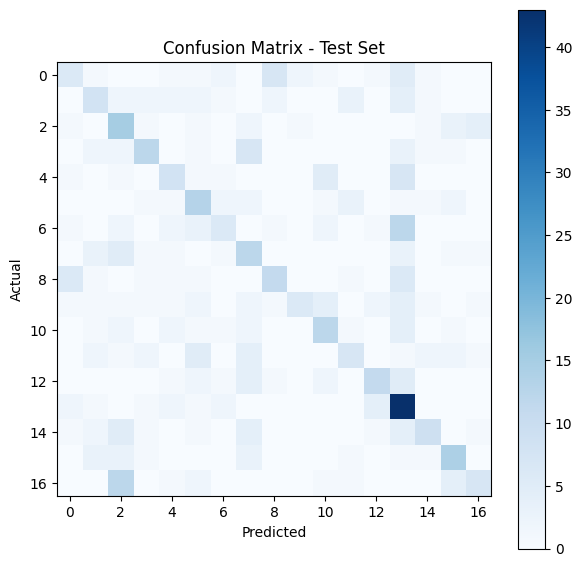

In [ ]:
test_gen.reset()
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,7))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/resnet50_celebrity_max_epochs.h5")
print("Model saved successfully")


Model saved successfully


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
img_path = val_gen.filepaths[0]  # any image from validation set

img = tf.keras.preprocessing.image.load_img(
    img_path, target_size=(224, 224)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


In [ ]:
heatmap = make_gradcam_heatmap(
    img_array,
    model,
    last_conv_layer_name="conv5_block3_out"  # ResNet50 last conv layer
)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_537']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


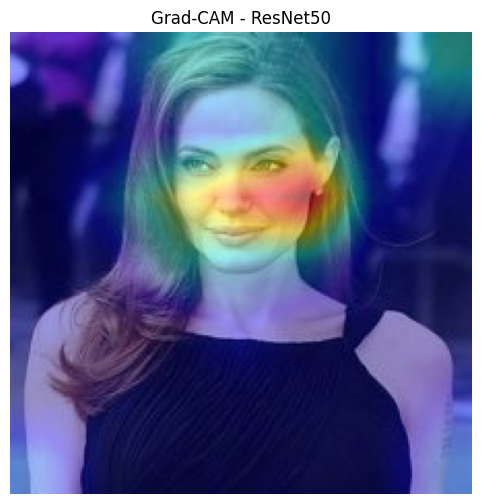

In [ ]:
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Grad-CAM - ResNet50")
plt.show()
